%run feature_engineering.ipynb

In [1]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import copy


import pandas as pd
import matplotlib as plt
import numpy as np
from sklearn.metrics import mean_squared_error


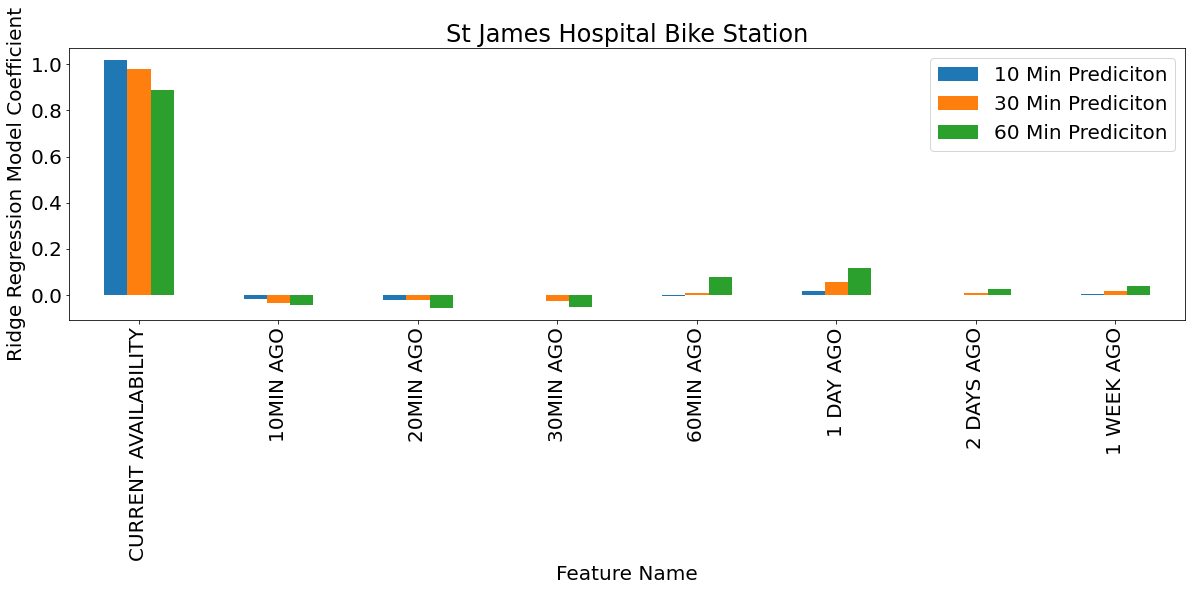

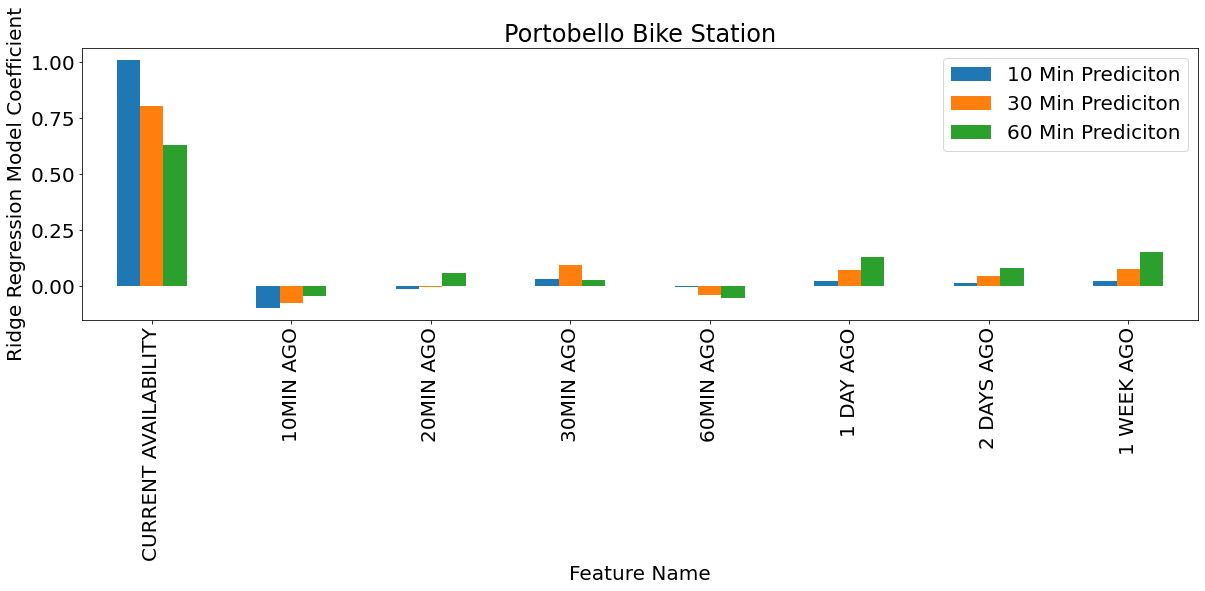

In [2]:
%run feature_engineering.ipynb

Lets save our variables from the previous notebook

In [3]:

df_hospital_map = df_hospital_map
df_portobello_map = df_portobello_map

X_hospital_map = X_hospital
y_hospital_map = y_hospital

X_portobello_map = X_portobello
y_portobello_map = y_portobello


In [4]:
def test_and_train_model(model, X, y):
    
    kf = KFold(n_splits=5)
    mse_scores=[]
    
    X = X.to_numpy()
    y = y.to_numpy()
    
    for train,test in kf.split(X):
        model.fit(X[train], y[train])
        ypred = model.predict(X[test])
        
        mse_scores.append(mean_squared_error(y[test], ypred))
    

    return np.mean(mse_scores), np.std(mse_scores)
    

In [5]:
def get_baseline_mse(X,y):
    ypred = X["CURRENT AVAILABILITY"]
    y = y.to_numpy()
    ypred = ypred.to_numpy()
    
    return mean_squared_error(y, ypred)


In [6]:

def cross_evaluate_models(model_name:str,hyper_param_range, X_map,y_map):
    

    cross_evaluation_map = {
        "C":[],
        "MEAN":[],
        "STD ERROR":[]
    }
    model_scores={
        "10MIN": copy.deepcopy(cross_evaluation_map),
        "30MIN":copy.deepcopy(cross_evaluation_map),
        "60MIN":copy.deepcopy(cross_evaluation_map)
    }
    
    

    for hyper_param in hyper_param_range:

        if model_name == "ridge":
            model = Ridge(alpha=1/(2*hyper_param))
        if model_name == "kNN":
            model = KNeighborsRegressor(n_neighbors=hyper_param, weights='distance',algorithm='ball_tree')

        for key in model_scores:
            
            scores = test_and_train_model(model, X_map[key], y_map[key])
            
            model_scores[key]["C"].append(hyper_param)
            model_scores[key]["MEAN"].append(scores[0])
            model_scores[key]["STD ERROR"].append(scores[1])


    return model_scores

In [7]:
def plot_cross_eval(model_scores,title,hyper_param_name):
    plt.figure(figsize=(30,10))
    plt.errorbar(model_scores["10MIN"]["C"],model_scores["10MIN"]["MEAN"],yerr=model_scores["10MIN"]["STD ERROR"], label = "10 min prediction")
    plt.errorbar(model_scores["30MIN"]["C"],model_scores["30MIN"]["MEAN"],yerr=model_scores["30MIN"]["STD ERROR"], label = "30 min prediction")
    plt.errorbar(model_scores["60MIN"]["C"],model_scores["60MIN"]["MEAN"],yerr=model_scores["60MIN"]["STD ERROR"], label = "60 min prediction")
    plt.legend()
    plt.xlabel(hyper_param_name)
    plt.ylabel("MSE")
    plt.title(title)

In [8]:

model_score_results={}
model_score_results["PORTOBELLO"]={}
model_score_results["PORTOBELLO"]["BASELINE"]={}
model_score_results["HOSPITAL"]={}
model_score_results["HOSPITAL"]["BASELINE"]={}

for key in X_portobello_map:
    model_score_results["PORTOBELLO"]["BASELINE"][key] = get_baseline_mse(X_portobello_map[key],y_portobello_map[key])
    model_score_results["HOSPITAL"]["BASELINE"][key] = get_baseline_mse(X_hospital_map[key],y_hospital_map[key])


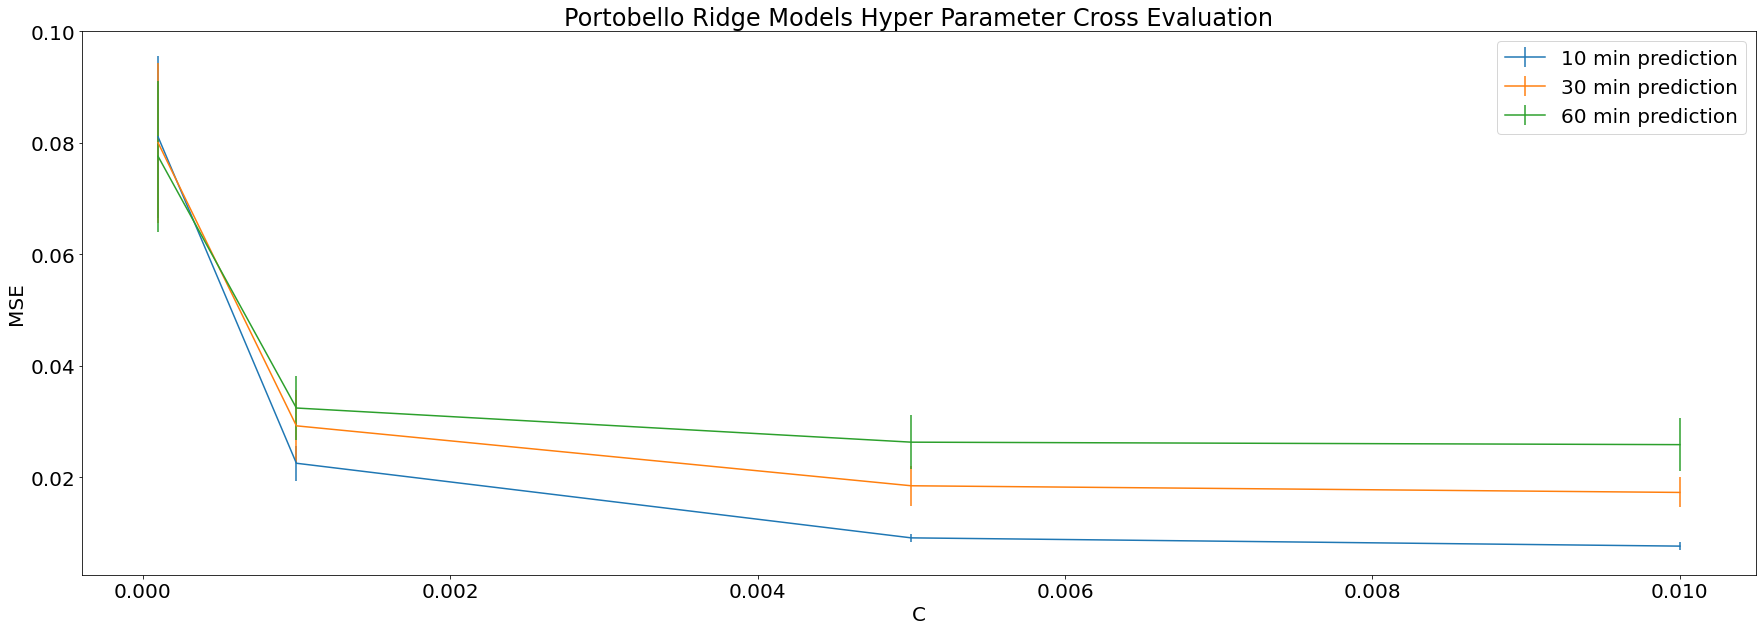

In [9]:
portobello_model_scores = cross_evaluate_models("ridge", [0.0001,0.001,0.005,0.01],X_portobello_map, y_portobello_map)

plot_cross_eval(portobello_model_scores,"Portobello Ridge Models Hyper Parameter Cross Evaluation","C")

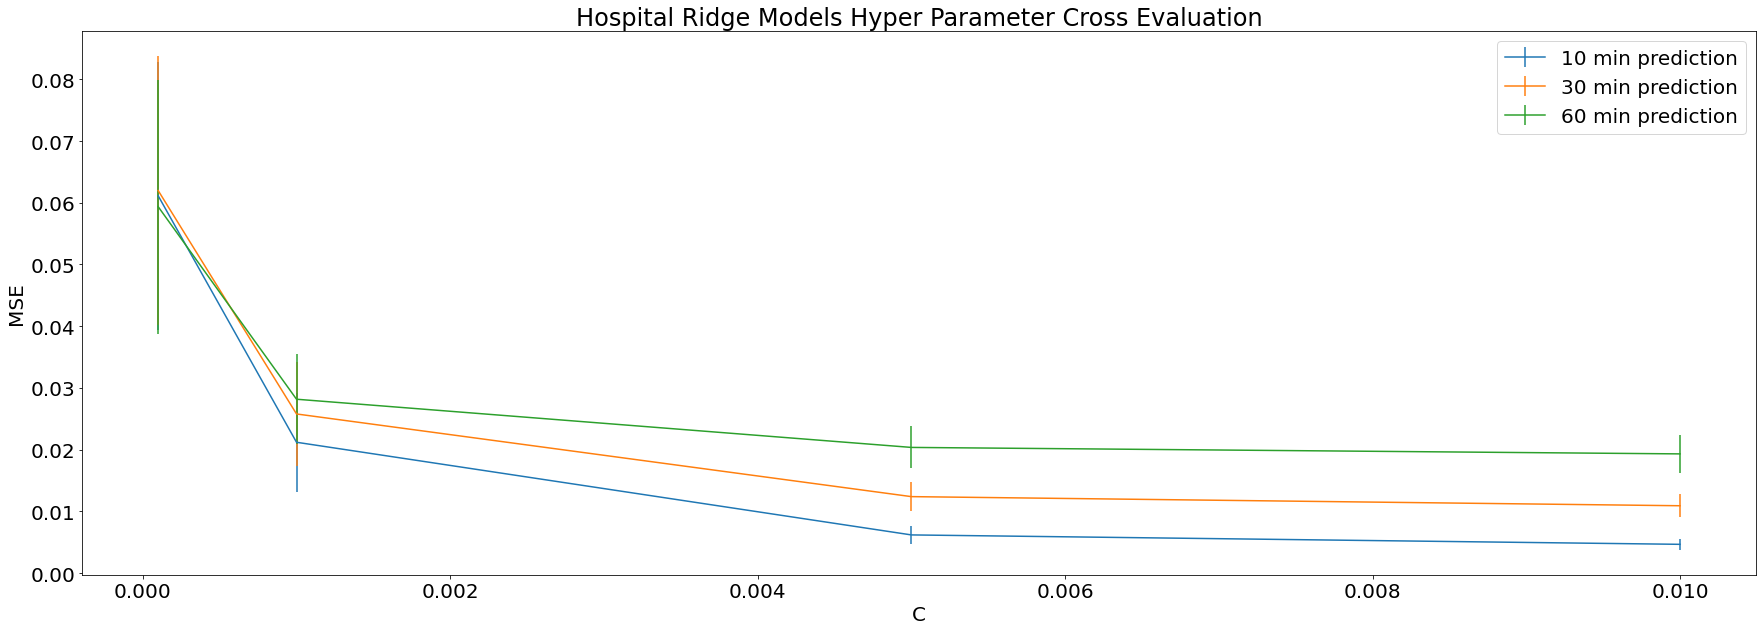

In [10]:
hospital_model_scores = cross_evaluate_models("ridge", [0.0001,0.001,0.005,0.01],X_hospital_map, y_hospital_map)

plot_cross_eval(hospital_model_scores,"Hospital Ridge Models Hyper Parameter Cross Evaluation","C")

In [11]:
model_score_results["HOSPITAL"]["RIDGE"]={}
model_score_results["PORTOBELLO"]["RIDGE"]={}

for key in hospital_model_scores:
    model_score_results["PORTOBELLO"]["RIDGE"][key]=portobello_model_scores[key]["MEAN"][2]
    model_score_results["HOSPITAL"]["RIDGE"][key]=hospital_model_scores[key]["MEAN"][2]

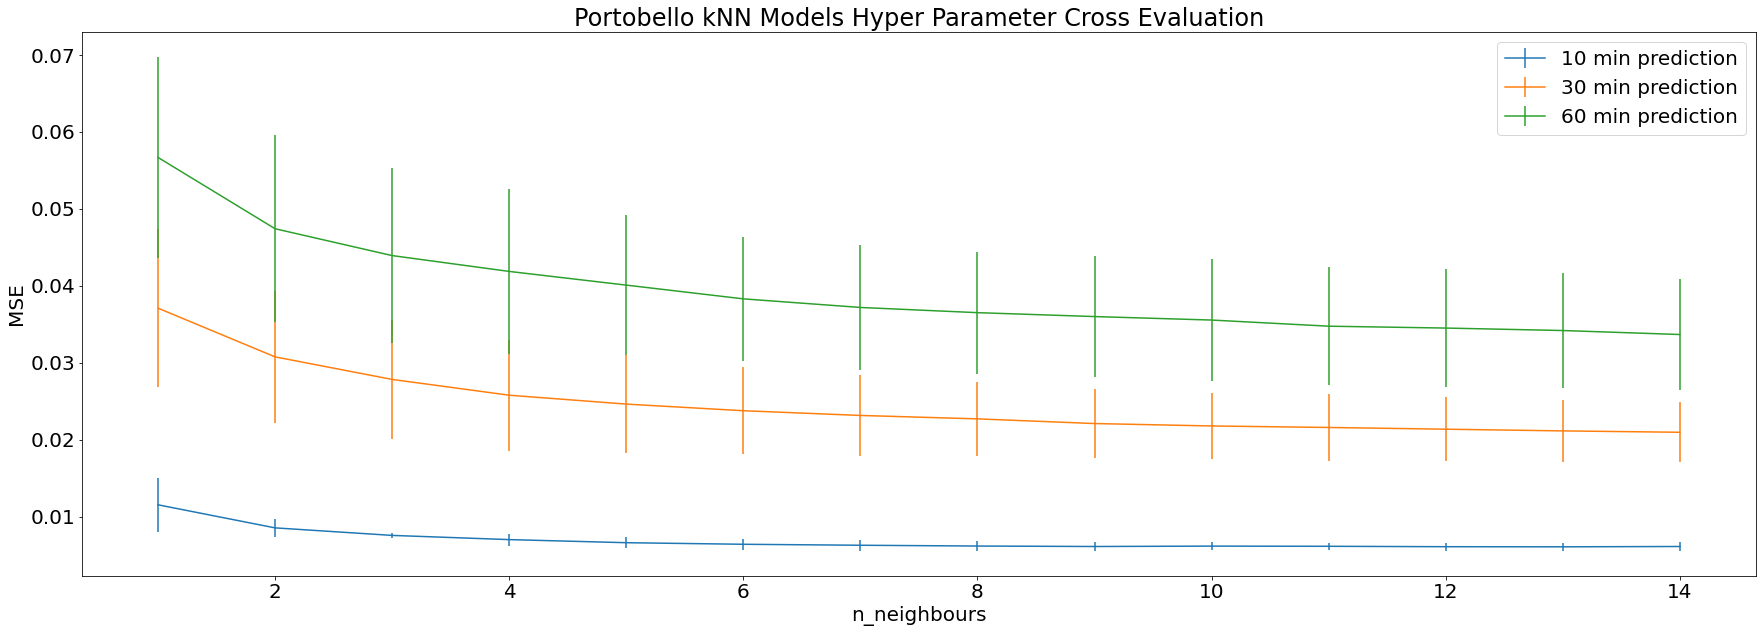

In [12]:
portobello_model_scores = cross_evaluate_models("kNN", range(1,15),X_portobello_map, y_portobello_map)

plot_cross_eval(portobello_model_scores,"Portobello kNN Models Hyper Parameter Cross Evaluation","n_neighbours")

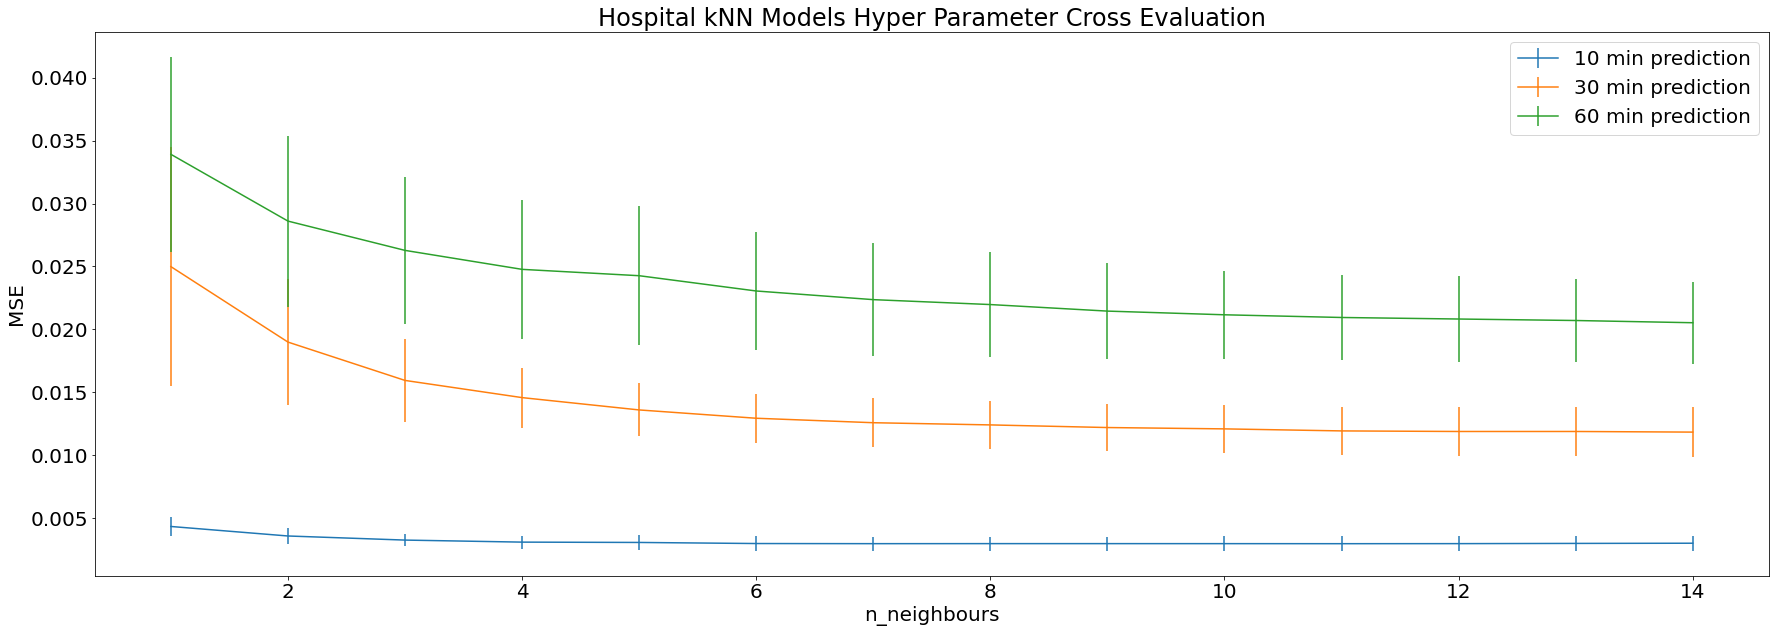

In [13]:
hospital_model_scores = cross_evaluate_models("kNN", range(1,15),X_hospital_map, y_hospital_map)

plot_cross_eval(hospital_model_scores,"Hospital kNN Models Hyper Parameter Cross Evaluation","n_neighbours")

In [14]:
model_score_results["HOSPITAL"]["KNN"]={}
model_score_results["PORTOBELLO"]["KNN"]={}

model_score_results["PORTOBELLO"]["KNN"]["10MIN"]=portobello_model_scores["10MIN"]["MEAN"][4]
model_score_results["HOSPITAL"]["KNN"]["10MIN"]=hospital_model_scores["10MIN"]["MEAN"][4]

model_score_results["PORTOBELLO"]["KNN"]["30MIN"]=portobello_model_scores["30MIN"]["MEAN"][10]
model_score_results["HOSPITAL"]["KNN"]["30MIN"]=hospital_model_scores["30MIN"]["MEAN"][10]

model_score_results["PORTOBELLO"]["KNN"]["60MIN"]=portobello_model_scores["60MIN"]["MEAN"][10]
model_score_results["HOSPITAL"]["KNN"]["60MIN"]=hospital_model_scores["60MIN"]["MEAN"][10]

In [15]:
pd.DataFrame(model_score_results["PORTOBELLO"])

,BASELINE,RIDGE,KNN
10MIN,0.005182,0.009137,0.006615
30MIN,0.017341,0.018484,0.021593
60MIN,0.031811,0.026307,0.034757


In [16]:
pd.DataFrame(model_score_results["HOSPITAL"])

,BASELINE,RIDGE,KNN
10MIN,0.002476,0.006175,0.003078
30MIN,0.009189,0.012380,0.011939
60MIN,0.019344,0.020355,0.020950


In [17]:
import matplotlib.dates as mdates
def visualise_models(model, df :pd.DataFrame, X_map, y_map, title:str):
    test=-1100
    train = np.size(X_map["10MIN"])+test
    
    ypreds={}
    for key in X_map:
        
        X=X_map[key].to_numpy()
        y=y_map[key].to_numpy()

        model.fit(X[:train],y[:train])
        ypreds[key] = model.predict(X[test:])


    plt.rc('font',size=20)
    plt.figure(figsize=(20,15))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%a - %d/%b'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.plot(df.iloc[test:].index,y_map["10MIN"][test:],label="actual",marker='o')
    plt.plot(df.iloc[test:].index,ypreds["10MIN"],label="10 min prediction")
    plt.plot(df.iloc[test:].index,ypreds["30MIN"],label="30 min prediction")
    plt.plot(df.iloc[test:].index,ypreds["60MIN"],label="60 min prediction",alpha=0.6)
    

    plt.xlim(df.iloc[test:].index[0],df.iloc[test::].index[-1])
    plt.legend()
    plt.gcf().autofmt_xdate()
    plt.xlabel("Time")
    plt.ylabel("Available Bikes")
    plt.title(title)

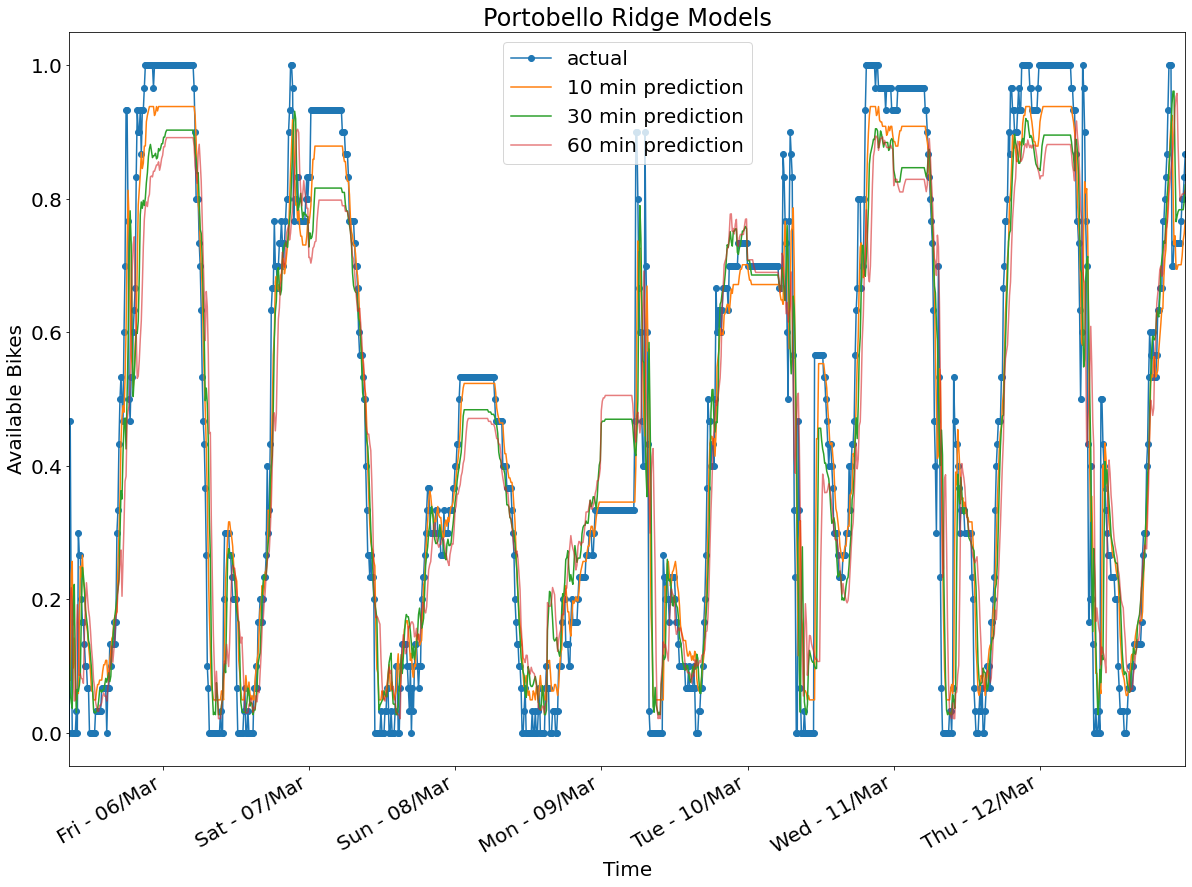

In [18]:
visualise_models(Ridge(alpha = 1/(2*0.005)),df_portobello_map["10MIN"],X_portobello_map,y_portobello_map,"Portobello Ridge Models")

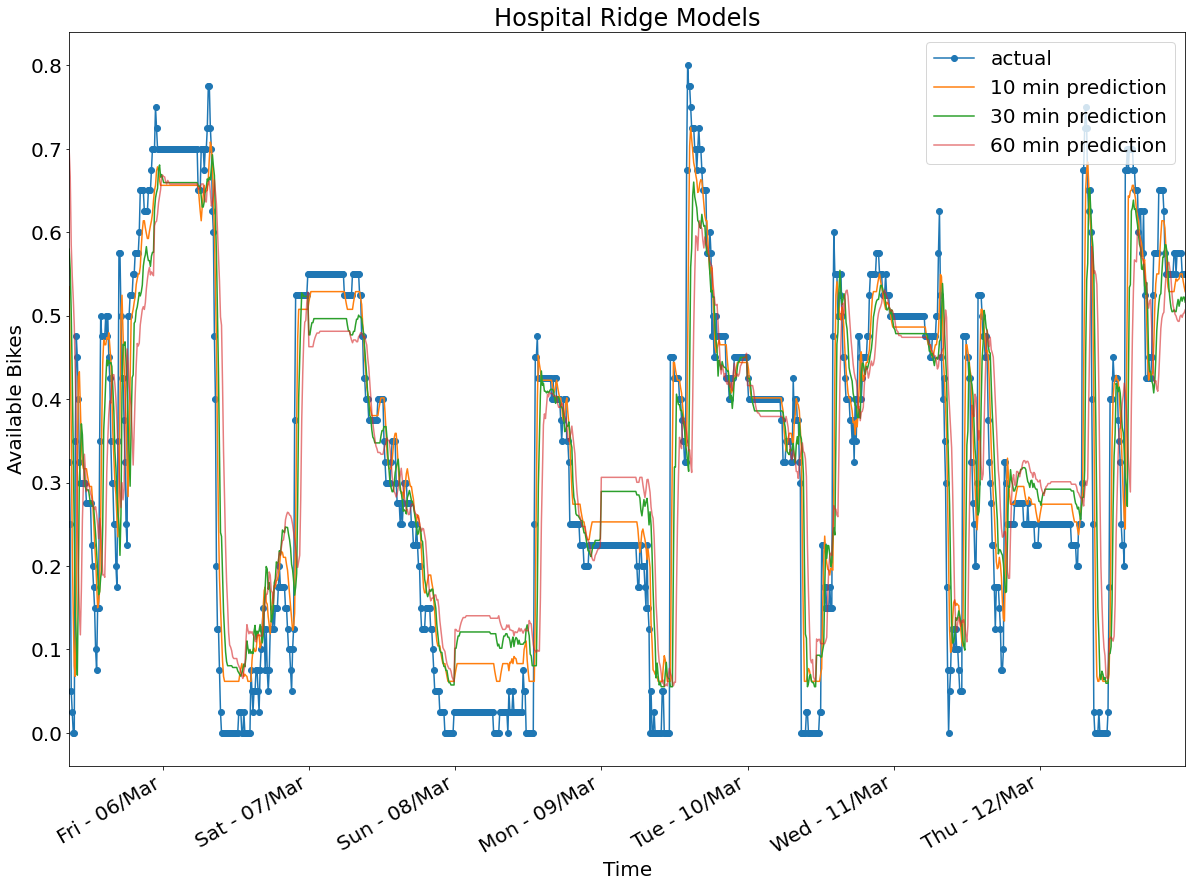

In [19]:
visualise_models(Ridge(alpha = 1/(2*0.005)),df_hospital_map["10MIN"],X_hospital_map,y_hospital_map,"Hospital Ridge Models")

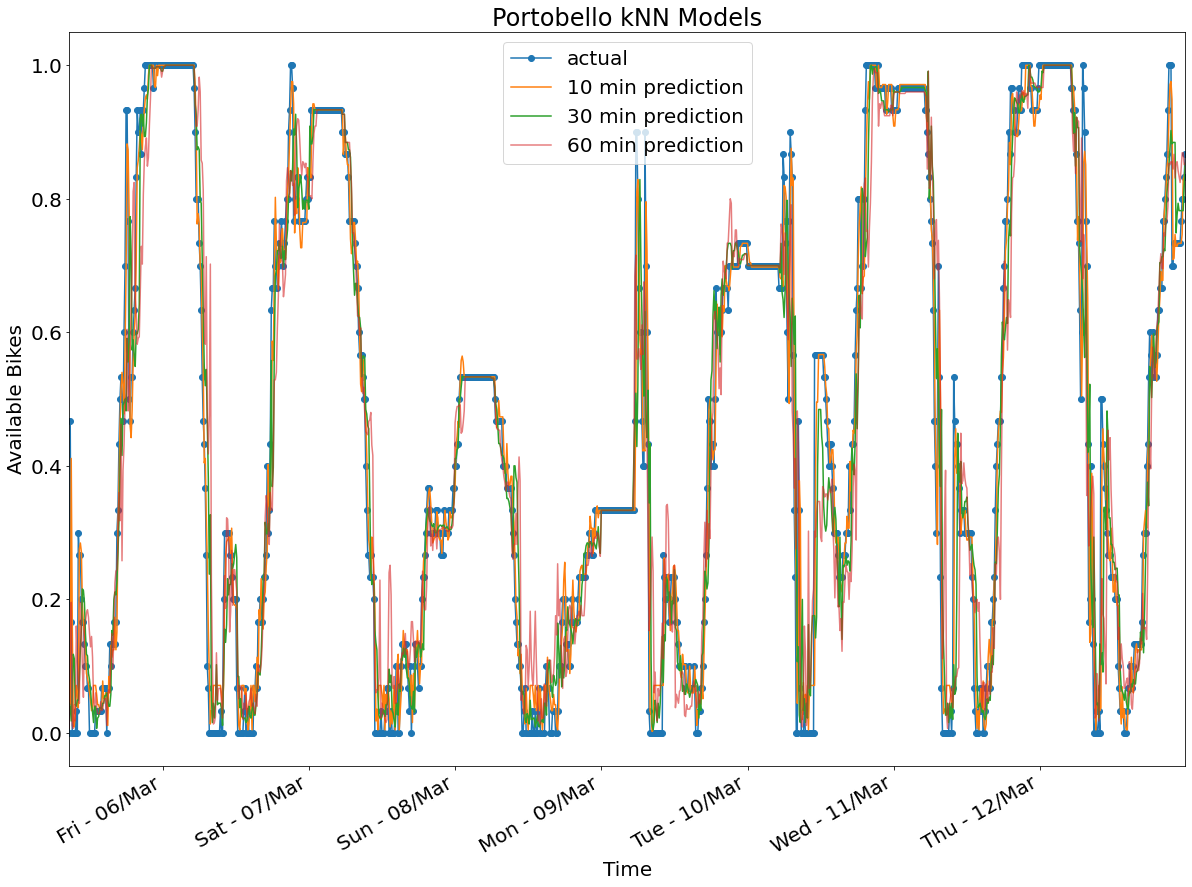

In [20]:
visualise_models(KNeighborsRegressor(n_neighbors=15),df_portobello_map["10MIN"],X_portobello_map,y_portobello_map,"Portobello kNN Models")

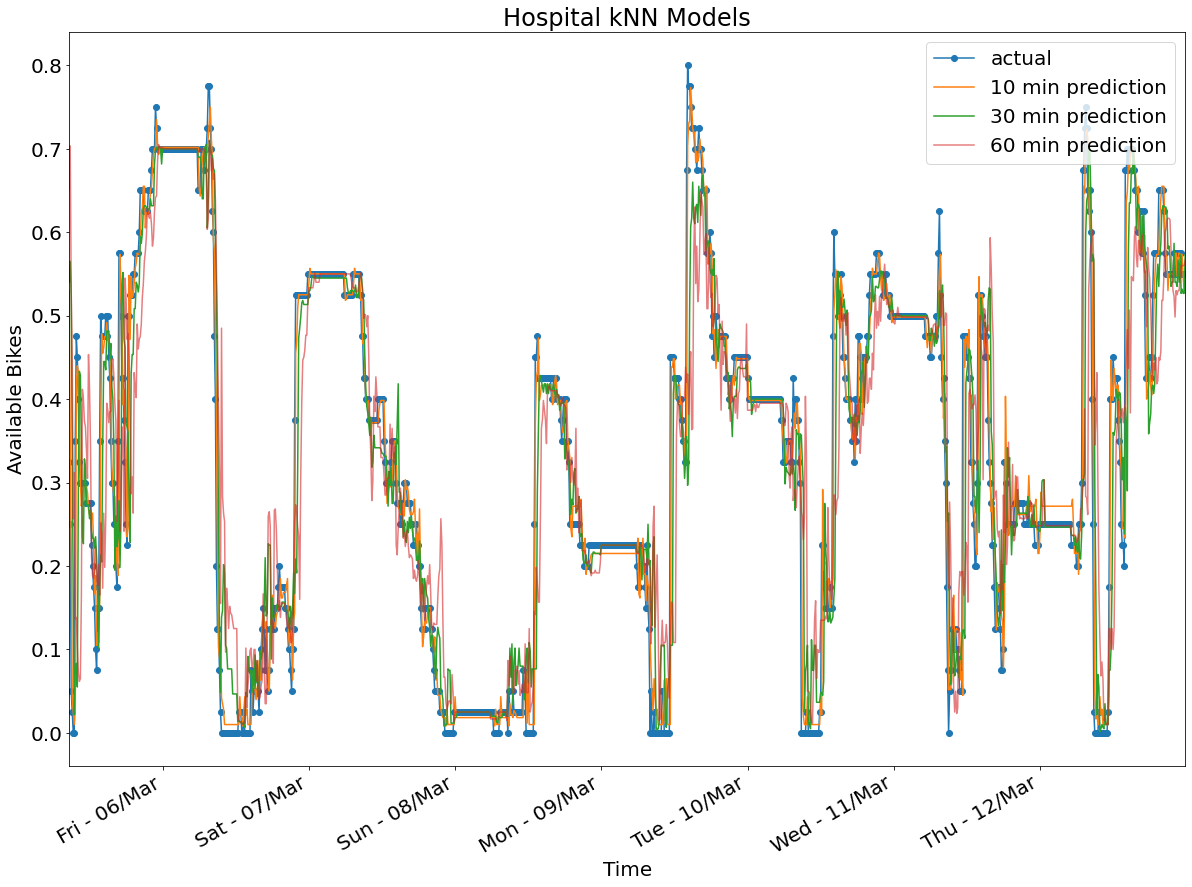

In [21]:
visualise_models(KNeighborsRegressor(n_neighbors=15),df_hospital_map["10MIN"],X_hospital_map,y_hospital_map,"Hospital kNN Models")